# Scoring update for Splicemod library #

The splicemod library was created more than five years and has an outdated scoring mechanism for splicing motifs. In this notebook, I will update the way we "score" sequences. The scoring for exonic/intronic splicing motifs were based on two papers from 2007. 

## Exonic motifs ##

Here, I will use a model from this [paper](http://www.sciencedirect.com/science/article/pii/S0092867415012714) by Shendure which learned an effect size for each exonic hexamer, jointly learned from two MPRAs studying alternative 5' and 3' splicing. All scores for 4,096 possible hexamers are learned at once through multiple linear regression. 

## Splice acceptors/donors ##

In the old version, we used MaxEnt to score the splice acceptor/donors. This is still a popular method for scoring so I will use this as well. Additionally, Shendure's paper learned separate effect sizes for the first three nucleotides of the exon which overlaps the splice acceptor. This model was trained on the alternative 3' splicing library and looks at the odds of splicing at a new splice acceptor depending on the +1 to +3 bases. I will score our exons in a similar manner and see how these scores compare to the MaxEnt scores.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
from helpful_utils import reverse_complement
%matplotlib inline
%load_ext rpy2.ipython

pd.set_option('display.float_format', lambda x:'%f'%x)

data = pd.read_table('../produced_data/splicemod_data_clean.txt', sep = '\t')
# reformat so intron/exon length columns are int and not float, convert NA to 0 so we can use int
data[['intron1_len', 'exon_len', 'intron2_len']] = data[['intron1_len', 'exon_len', 'intron2_len']].fillna(0.0).astype(int)
data.head()

,id,ensembl_id,sub_id,chr,start,end,strand,intron1_len,exon_len,intron2_len,...,new_score,criteria_met,max_iter_reached,no_new_mutants,index_R1,index_R2,index_diff,dpsi_R1,dpsi_R2,high_confidence
1,CTRL1831_001,CTRL1831,1,NaN,nan,nan,nan,0,0,0,...,nan,NaN,NaN,NaN,0.000000,0.000000,0.000000,nan,nan,False
2,CTRL1831_002,CTRL1831,2,NaN,nan,nan,nan,0,0,0,...,nan,NaN,NaN,NaN,0.000000,0.059056,0.059056,nan,nan,False
3,CTRL1831_007,CTRL1831,7,NaN,nan,nan,nan,0,0,0,...,nan,NaN,NaN,NaN,0.850000,1.000000,0.150000,nan,nan,False
4,CTRL1831_009,CTRL1831,9,NaN,nan,nan,nan,0,0,0,...,nan,NaN,NaN,NaN,0.000000,0.000000,0.000000,nan,nan,False
5,CTRL2575_001,CTRL2575,1,NaN,nan,nan,nan,0,0,0,...,nan,NaN,NaN,NaN,0.000000,0.000000,0.000000,nan,nan,False


In [2]:
def extract_exon_seq(strand, intron1_len, exon_len, intron2_len, seq):
    # extract exon sequence based on strand and intron/exon lengths
    seq = seq.upper()
    if strand == 1:
        exon_seq = seq[intron1_len : intron1_len + exon_len]
    
    elif strand == -1:
        seq = reverse_complement(seq)
        exon_seq = seq[intron2_len : intron2_len + exon_len]
    
    else:
        exon_seq = ''
    
    return exon_seq

data['exon_seq'] = [extract_exon_seq(data.iloc[i]['strand'],
                                    data.iloc[i]['intron1_len'],
                                    data.iloc[i]['exon_len'],
                                    data.iloc[i]['intron2_len'],
                                    data.iloc[i]['seq']) for i in range(len(data))]

Now that we have the exon sequences for our library, let's bring in the score matrices and give an effect size sum score for each sequence. A higher score means the hexamer is more likely to active nearby splice sites and promote exon inclusion (to be an ESE, exonic splicing enhancer). A negative score means the hexamer is an exonic splicing silencer and promotes exon skipping.

In [3]:
exonic_mer6_scores = pd.read_pickle('../../ref/Rosenberg_2015/exonic_mer6_scores.series')
exonic_mer6_scores.head()

AAAAAA   -0.042248
AAAAAC    0.008674
AAAAAG   -0.318314
AAAAAT   -0.311447
AAAACA   -0.096887
dtype: float64

In [4]:
def calculate_exonic_score(exon_seq, exonic_mer6_scores):
    # given a score matrix and an exon sequence, return the average effect size for the sequence 
    # (sum of all k-mer scores / number of k-mers)
    # do not score first three bases of exons which overlap with splice acceptor region
    if exon_seq == '':
        return float('NaN')
    kmer_scores = [exonic_mer6_scores[exon_seq[i : i+6]] for i in range(3, len(exon_seq) - 6)]
    score_avg = sum(kmer_scores) / len(kmer_scores)
    return score_avg
        
data['avg_exon_effect_score'] = [calculate_exonic_score(data.iloc[i]['exon_seq'], exonic_mer6_scores) for i in range(len(data))]   

In [5]:
data.avg_exon_effect_score.describe()

/Users/Kimberly/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


count   16063.000000
mean        0.018644
std         0.039801
min        -0.226260
25%              nan
50%              nan
75%              nan
max         0.201790
Name: avg_exon_effect_score, dtype: float64

In [6]:
# I don't want to deal with Python plotting, so output results to file and read in with R
data.to_csv('../produced_data/splicemod_exon_scores.txt', sep ='\t', index = False, na_rep = 'NA')

In [7]:
%%R
library(ggplot2)
library(dplyr)
library(cowplot)
options(stringsAsFactors = F)
# setwd('/Users/Kimberly/Documents/projects/splicing/splicemod_lib/notebooks')
data <- read.table('../produced_data/splicemod_exon_scores.txt', sep = '\t', header = T)

/Users/Kimberly/anaconda2/lib/python2.7/site-packages/rpy2-2.8.5-py2.7-macosx-10.6-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/Users/Kimberly/anaconda2/lib/python2.7/site-packages/rpy2-2.8.5-py2.7-macosx-10.6-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/Users/Kimberly/anaconda2/lib/python2.7/site-packages/rpy2-2.8.5-py2.7-macosx-10.6-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/Users/Kimberly/anaconda2/lib/python2.7/site-packages/rpy2-2.8.5-py2.7-macosx-10.6-x86_64.egg/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘cowplot’


  warnings.warn(x, RRuntimeWarning)
/Users/Kimberly/anaconda2/lib/python2.7/site-pa

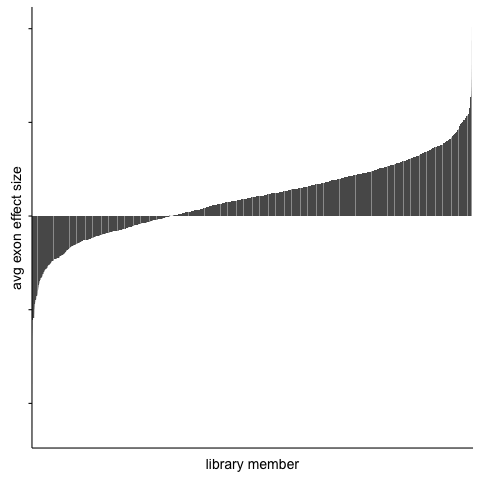

In [8]:
%%R
data$id <- factor(data$id, levels = data$id[order(data$avg_exon_effect_score)])
ggplot(data, aes(x = id, y = avg_exon_effect_score)) + 
    geom_bar(stat = 'identity') +
    theme(axis.text.x = element_blank(), axis.text.y = element_blank(), axis.ticks.x = element_blank()) +
    labs(x = 'library member', y = 'avg exon effect size')

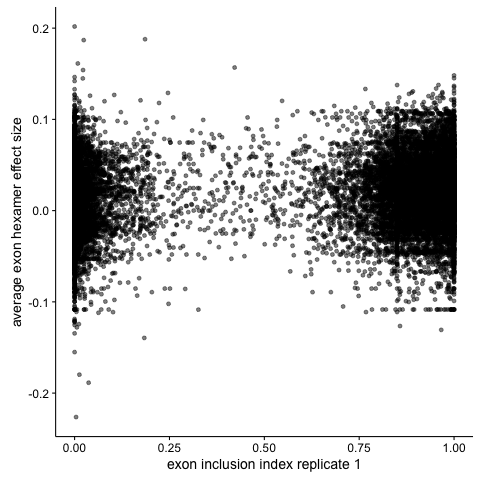

In [9]:
%%R

ggplot(data, aes(index_R1, avg_exon_effect_score)) + geom_point(alpha = 0.50) +
    labs(x = 'exon inclusion index replicate 1', y = 'average exon hexamer effect size')

To get a better sense of how the hexamer score relates to the exon inclusion index, let's calculate the difference in average hexamer score between each mutant and it's natural sequence.

In [10]:
%%R
delta_score <- function(df){
    nat_seq = filter(df, seq_type == 'nat')
    if ( nrow(nat_seq) == 0 ) { # control exon
        ref_score <- NA
    }
    else{
        ref_score <- nat_seq$avg_exon_effect_score
    }
    df <- df %>%
        mutate(delta_exon_score = df$avg_exon_effect_score - ref_score)
    return(df)
}

data <- data %>% 
    group_by(ensembl_id) %>% 
    do(delta_score(.)) %>% 
    ungroup()

|===================================================== |100% ~0 s remaining     

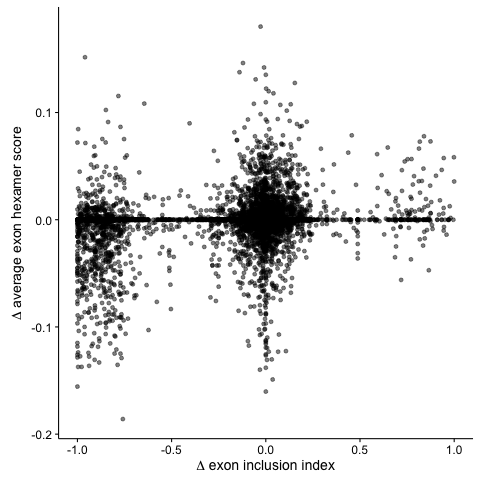

In [11]:
%%R

ggplot(data, aes(dpsi_R1, delta_exon_score)) + geom_point(alpha = 0.50) +
    labs(x = expression(paste(Delta, ' exon inclusion index')),
        y = expression(paste(Delta, ' average exon hexamer score')))

In [12]:
%%R
summary(lm(delta_exon_score ~ dpsi_R1, data))


Call:
lm(formula = delta_exon_score ~ dpsi_R1, data = data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.178516 -0.000310 -0.000310  0.000748  0.180116 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0003103  0.0001449   2.142   0.0322 *  
dpsi_R1     0.0101623  0.0004207  24.158   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01628 on 14241 degrees of freedom
  (1883 observations deleted due to missingness)
Multiple R-squared:  0.03937,	Adjusted R-squared:  0.0393 
F-statistic: 583.6 on 1 and 14241 DF,  p-value: < 2.2e-16



In [13]:
%%R
cor.test(data$delta_exon_score, data$dpsi_R1)


	Pearson's product-moment correlation

data:  data$delta_exon_score and data$dpsi_R1
t = 24.158, df = 14241, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1825858 0.2141391
sample estimates:
      cor 
0.1984139 



The change in exon hexamer score and change in exon inclusion index are positively correlated. When a mutant sequence has a weaker average exon score (negative delta exon score, more ESS like, promote exon skipping), it is more likely to have a decreased level of exon inclusion relative to the natural sequence(negative delta PSI, more exon skipping).

When a mutant sequence has a stronger average exon hexamer score (positive delta exon score, more ESE like, promote exon inclusion), it is more likely to have an increased level of exon inclusion relative to the natural sequence (positive delta PSI, more exon inclusion).

Let's look a quick look at the exon inclusion index and see that everything is making sense.

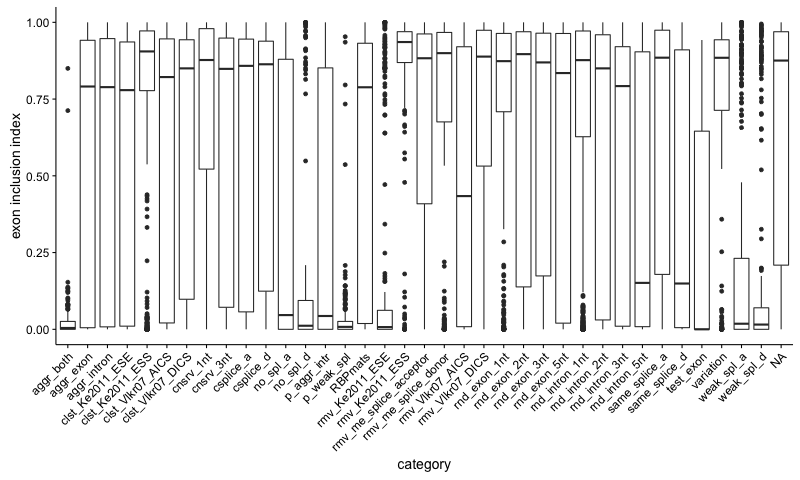

In [14]:
%%R -w 800 -h 480 -u px
ggplot(data, aes(x = category, y = index_R1)) + geom_boxplot() + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
labs(y = 'exon inclusion index')

We can see things are making sense (Rocky has shown versions of these graphs before). Now, let's look at the exon hexamer scores.

Let's look at the average exon hexamer score across different mutation categories.

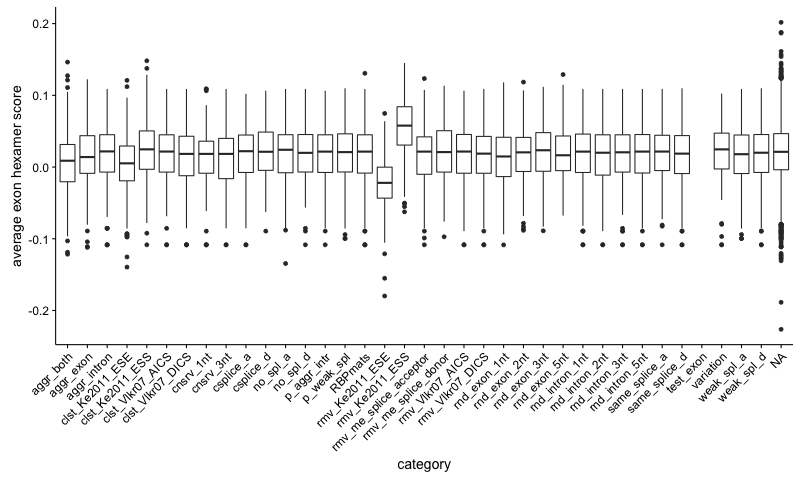

In [15]:
%%R -w 800 -h 480 -u px
ggplot(data, aes(x = category, y = avg_exon_effect_score)) + geom_boxplot() + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(y = 'average exon hexamer score')

The  important categories to pay attention to are the categories where ESEs and ESSs are altered (clust_Ke2011_ESE, clst_Ke2011_ESS) or removed (rmv_Ke2011_ESE, rmv_Ke2011_ESS). When ESEs are altered or removed, the average exon hexamer score goes down, which makes sense. This change is most noticeable when the ESEs are completely removed instead of just mutated. Conversely, when the ESSs are altered or removed, the average exon hexamer score increases, with the largest change seen when they are completely removed.

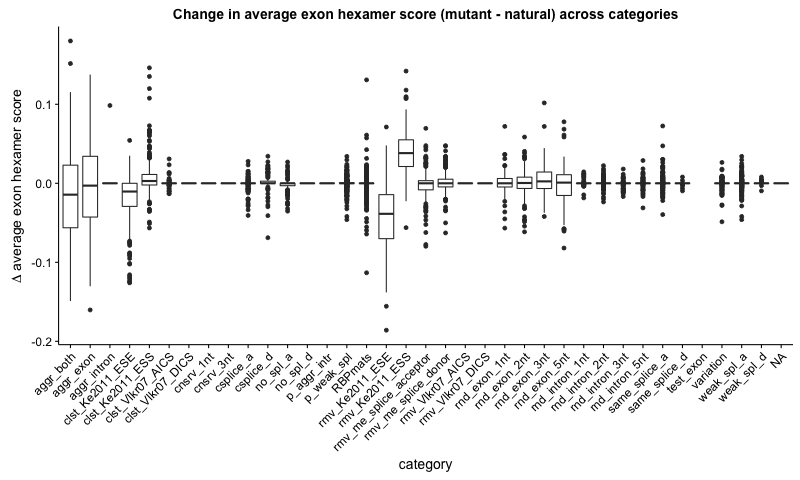

In [16]:
%%R -w 800 -h 480 -u px
ggplot(data, aes(x = category, y = delta_exon_score)) + geom_boxplot() + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
labs(y = expression(paste(Delta, ' average exon hexamer score')),
    title = 'Change in average exon hexamer score (mutant - natural) across categories')

The same conclusions hold when we look at the change in exon hexamer score across categories. A positive delta means
the mutant sequence has a stronger average exon score than the natural sequence.

Let's read in the ESE and ESS motifs from Ke 2011 and see how their scores compare with these updated effect sizes.

In [17]:
ESE_motifs = pd.read_table('../../splicemod/data/motifs/Ke2011/ESEseq.txt',
                          sep = '\t', header = None, names = ['seq', 'Ke_score'])
ESS_motifs = pd.read_table('../../splicemod/data/motifs/Ke2011/ESSseq.txt',
                          sep = '\t', header = None, names = ['seq', 'Ke_score'])
Ke_motifs = pd.concat([ESE_motifs, ESS_motifs])
Ke_motifs.head()

,seq,Ke_score
0,AGAAGA,1.034000
1,GAAGAT,0.992000
2,GACGTC,0.984000
3,GAAGAC,0.964000
4,TCGTCG,0.952000


In [18]:
print np.mean(ESE_motifs.Ke_score)
print np.mean(ESS_motifs.Ke_score)

0.387866328257
-0.378094495413


In [19]:
df = pd.DataFrame(exonic_mer6_scores)
df.reset_index(level = 0, inplace = True)
df.columns = ['seq', 'HAL_score']

all_motifs = df.merge(Ke_motifs, how = 'left', on = 'seq')
all_motifs.head()

,seq,HAL_score,Ke_score
0,AAAAAA,-0.042248,nan
1,AAAAAC,0.008674,nan
2,AAAAAG,-0.318314,nan
3,AAAAAT,-0.311447,-0.343000
4,AAAACA,-0.096887,nan


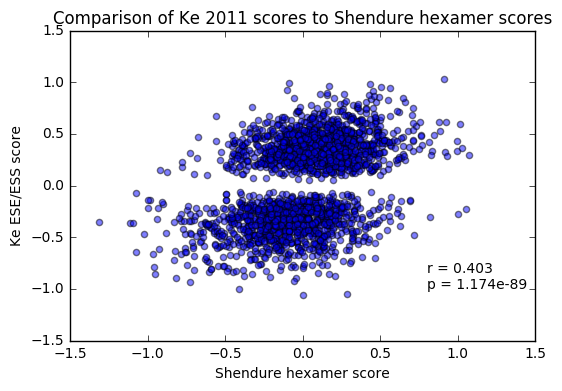

In [20]:
from scipy.stats import pearsonr
corr, corr_pval = pearsonr(all_motifs.dropna().HAL_score, all_motifs.dropna().Ke_score)

plt.scatter(all_motifs.HAL_score, all_motifs.Ke_score, alpha = 0.50)
plt.title('Comparison of Ke 2011 scores to Shendure hexamer scores')
plt.xlabel('Shendure hexamer score')
plt.ylabel('Ke ESE/ESS score')
plt.text(0.8, -1.0, 'r = {} \np = {:.3e}'.format(round(corr, 3), corr_pval))

## Splice donor/acceptor scoring ##

In order to score the splice donor/acceptor, we must have intron/exon boundaries for the sequence. The consensus sequence for the 5′ splice site (donor) to the 9-mer (C or A)AG GTRAGT and the 3′ splice site (acceptor) to the 15-mer Y10NCAG G (spacing refers to intron/exon boundary). The GT is nearly invariant in the splice donor and the AG is nearly invariant in the splice acceptor. For MaxEnt, we need 3 bases in the exon and 6 bases in the intron to search for splice donor sites. For splice acceptor, we need 20 bases in the intron and 3 in the exon. For the splice donor, the invariant GT occurs at positions (3,4) (0-based). For the splice acceptor, the invariant AG occurs at positions (18,19) (0-based). For each sequence, we will tile the sequence and generate all n-mers, excluding those shorter than the motif length. We will only score those n-mers that have the correct invariant positions. We will record all n-mers, location, and score and filter later for those that fall in the correct context.

We will use a lot of the splicemod code used to score sequences using MaxEnt.

In [21]:
import sys
sys.path.append('../../splicemod/src')
import util
import feature
import motif
import Bio
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Seq import Seq

/Users/Kimberly/Documents/projects/splicing/splicemod/data/ccds_ensembl/


/Users/Kimberly/anaconda2/lib/python2.7/site-packages/Bio/Motif/__init__.py:26: BiopythonDeprecationWarning: The module Bio.Motif has been deprecated and will be removed in a future release of Biopython. Instead please use the new module Bio.motifs instead. Please be aware that though the functionality of Bio.Motif is retained (and extended) in Bio.motifs, usage may be different.
  BiopythonDeprecationWarning)


Loading position frequency matrices from RBPmats...
Motif matrices done.



Let's format our library into `SeqRecord` objects from `biopython` to make the motif finding easier and compatible with existing code.

In [22]:
lib = data[(data.strand == -1) | (data.strand == +1)]
len(lib)

16063

In [23]:
def create_record(seq, intron1_len, intron2_len, exon_len, strand, name):
    seq = seq.upper()
    if strand == -1:
        seq = reverse_complement(seq)
        upstr_intron_len = intron2_len
        downstr_intron_len = intron1_len
    else:
        upstr_intron_len = intron1_len
        downstr_intron_len = intron2_len
        
    record = SeqRecord(Seq(seq), id = name)
    record.seq.alphabet = Bio.Alphabet.DNAAlphabet()
    record.annotations['upstr_intron_size'] = upstr_intron_len
    record.annotations['downstr_intron_size'] = downstr_intron_len
    record.annotations['exon_size'] = exon_len
    
    # create intron/exon features
    upstr_loc = (0,record.annotations["upstr_intron_size"])
    exon_loc = (upstr_loc[1],upstr_loc[1]+record.annotations["exon_size"])
    downstr_loc = (exon_loc[1],exon_loc[1]+
                       record.annotations["downstr_intron_size"])
    
    # upstream intron
    record.features.append(SeqFeature(FeatureLocation(*upstr_loc),
                type= "intron", strand = strand))

    # exon
    record.features.append(SeqFeature(FeatureLocation(*exon_loc),
                type = "exon", strand = strand))
    # downstream intron
    record.features.append(SeqFeature(FeatureLocation(*downstr_loc),
                type = "intron", strand = strand))
    
    return record

In [ ]:
lib_records = [create_record(lib.seq.iloc[i], lib.intron1_len.iloc[i],
                            lib.intron2_len.iloc[i], lib.exon_len.iloc[i],
                            lib.strand.iloc[i], lib.id.iloc[i]) 
              for i in range(len(lib))]

In [ ]:
maxent_motifs = {mtf : motif.motif_types[mtf] for mtf in motif.motif_types
                     if 'me_splice' in mtf}
maxent_motifs

In [ ]:
for record in lib_records:
    for motif_type in maxent_motifs.values():
        record.find_motifs(motif_type)

The class function `find_motifs` will search all n-mers that match the length requirement for the motif and score it, creating a `SeqFeature` object containing the location, type of motif, and score, which is added to the `features` attribute of each `record`. For MaxEnt motifs there is no filtering of scores - if MaxEnt returns a score, it is stored in the record.

Now that we have all have the splice donors/acceptors for each sequence, let's go back through and check that each feature is in the correct location: if it is a donor, does it occur at the 3' border of an exon, and if it is an acceptor, does it occur at the 5' border.

In [ ]:
forced_signals = []
for record in lib_records:
    record.exon_list = []
    record.get_exon_list()
    record.get_correct_motifs()
    # this function grabs the sequence at the canonical position for the splice donor/acceptor, scores it and marks it
    # correct, regardless of score
    record.force_splice_signals()
    if len(record.correct_motifs) == 0:
        forced_signals.append(record)
    # update correct motif list after forcing signals
    for feature in record.features:
        if 'function' in feature.qualifiers:
            if 'correct splice signal' in feature.qualifiers['function'] and feature not in record.correct_motifs:
                record.correct_motifs.append(feature)

In [ ]:
pickle.dump(lib_records, open('lib_records.pkl', 'w'))

In [24]:
lib_records = pickle.load(open('lib_records.pkl'))

Let's create two columns, one each for the score of the correct splice acceptor and correct splice donor. We'll import this into R to do some simple modeling.

In [25]:
data['correct_acc_seq'] = [''] * len(data)
data['correct_acc_score'] = [float('NaN')] * len(data)
data['correct_don_seq'] = [''] * len(data)
data['correct_don_score'] = [float('NaN')] * len(data)
data.set_index('id', drop=False, inplace=True)

In [26]:
for record in lib_records:
    index = data[data.id == record.id].index.tolist()
    for feat in record.correct_motifs:
        if feat.type == 'me_splice_acceptor':
            data.set_value(index, 'correct_acc_seq', str(record.seq)[feat.extract_pos()[0]:feat.extract_pos()[1]])
            data.set_value(index, 'correct_acc_score', feat.extract_score())
        if feat.type == 'me_splice_donor':
            data.set_value(index, 'correct_don_seq', str(record.seq)[feat.extract_pos()[0]:feat.extract_pos()[1]])
            data.set_value(index, 'correct_don_score', feat.extract_score())

In [28]:
data.to_csv('../produced_data/splicemod_exon_acc_don_scores.txt', sep ='\t', index = False, na_rep = 'NA')

In [29]:
%%R
data <- read.table('../produced_data/splicemod_exon_acc_don_scores.txt', sep = '\t', header = T)

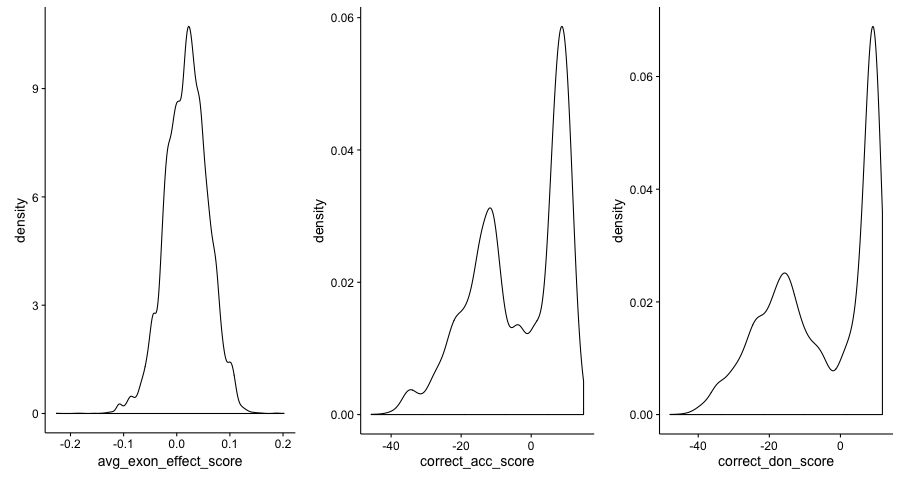

In [30]:
%%R -w 900 -h 480 -u px
plot_grid(ggplot(data, aes(avg_exon_effect_score)) + geom_density(),
         ggplot(data, aes(correct_acc_score)) + geom_density(),
         ggplot(data, aes(correct_don_score)) + geom_density(), nrow = 1)

The distribution of correct splicing/donor scores has a peak above zero indicating the sequence at the canonical position had a good score according to MaxEnt. However, there is still a big part of the distribution that falls below zero. This may be due to mis-annotation of the intron/exon boundaries or that sequence truly does not have a high scoring splice donor/acceptor sequence. I'll look into this later.

For now, let's try to fit a simple model using the average exon effect size, the score of the splice acceptor, and the score of the splice donor to predict the exon inclusion index. I'll first subset to those sequences with a positive acceptor and donor score.

In [31]:
%%R
lib <- data %>%
    filter(seq_type != 'control', correct_acc_score >= 0, correct_don_score >= 0)
nrow(lib)

[1] 7283


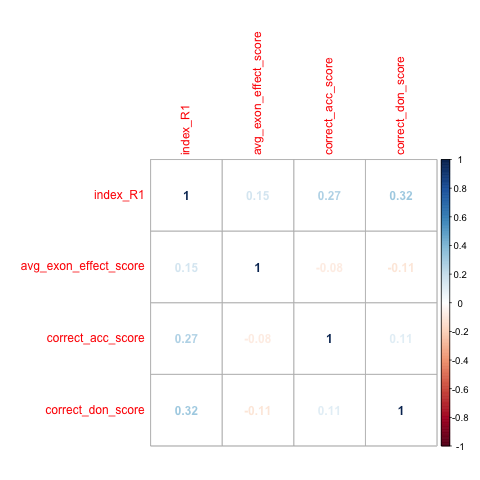

In [32]:
%%R
features <- select(lib, index_R1, avg_exon_effect_score, correct_acc_score, correct_don_score)

library('corrplot')
# taken from corrplot intro vignette
cor.mtest <- function(mat, conf.level = 0.95){
  mat <- as.matrix(mat)
    n <- ncol(mat)
    p.mat <- lowCI.mat <- uppCI.mat <- matrix(NA, n, n)
    diag(p.mat) <- 0
    diag(lowCI.mat) <- diag(uppCI.mat) <- 1
    for(i in 1:(n-1)){
        for(j in (i+1):n){
            tmp <- cor.test(mat[,i], mat[,j], conf.level = conf.level)
            p.mat[i,j] <- p.mat[j,i] <- tmp$p.value
            lowCI.mat[i,j] <- lowCI.mat[j,i] <- tmp$conf.int[1]
            uppCI.mat[i,j] <- uppCI.mat[j,i] <- tmp$conf.int[2]
        }
    }
    return(list(p.mat, lowCI.mat, uppCI.mat))
}

pvals <- cor.mtest(features)
feature_corr <- cor(features)
# leave blank for insignifcant correlations
corrplot(feature_corr, p.mat = pvals[[1]], method = 'number', insig = 'blank')

It seems there is some correlation between the acceptor/donor scores and the exon inclusion index, a weaker one for exon score. There also seems to be little correlation between the features, which is good for a model.

In [33]:
%%R
fit <- lm(index_R1 ~ avg_exon_effect_score + correct_acc_score + correct_don_score, lib)
summary(fit)


Call:
lm(formula = index_R1 ~ avg_exon_effect_score + correct_acc_score + 
    correct_don_score, data = lib)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0270 -0.3431  0.1321  0.2864  1.1463 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -0.206828   0.019769  -10.46   <2e-16 ***
avg_exon_effect_score  2.262921   0.113913   19.86   <2e-16 ***
correct_acc_score      0.036666   0.001539   23.83   <2e-16 ***
correct_don_score      0.054341   0.001820   29.86   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3776 on 7279 degrees of freedom
Multiple R-squared:  0.201,	Adjusted R-squared:  0.2007 
F-statistic: 610.3 on 3 and 7279 DF,  p-value: < 2.2e-16



Hmm, not a bad $R^2$, there may be something there. Let's plot the observed index values vs. model predicted values.

In [34]:
%%R

lib <- lib %>%
    mutate(predicted_index = predict(fit, .))

cor.test(lib$index_R1, lib$predicted_index)


	Pearson's product-moment correlation

data:  lib$index_R1 and lib$predicted_index
t = 42.795, df = 7281, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4297689 0.4664750
sample estimates:
      cor 
0.4483109 



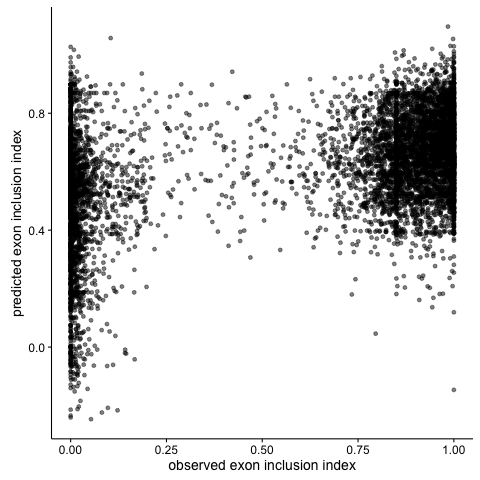

In [35]:
%%R
ggplot(lib, aes(index_R1, predicted_index)) + geom_point(alpha = 0.50) +
    labs(x = 'observed exon inclusion index', y = 'predicted exon inclusion index')

Although not apparently obvious from the graph, a simple model incorporating the average exon hexamer effect size, the splice donor score, and the splice acceptor score explains some of the variation in exon inclusion index ($R^2$ = 0.20) and there is moderate and siginificant correlation between the predicted and observed results (r = 0.448). The exon inclusion index (with the current data) is a somewhat binary value, with many values falling at the extremes of 0 and 1, so the performance of this simple model may be inflated.